# 程宇达+孟茗瑶 数据分析报告 代码

## 全局说明  
1. 运行代码之前，请确保您已经安装“导入相关模块”一节中提到的库，配置好环境。  
2. 数据准备：请将'report.ipynb'、'sentiment.ipynb'、'gooddata.xlsx'、'baddata.xlsx'、'stopwords.txt'、'reservedwords.txt'、'mergewords.txt'置于同一目录下。
3. 许可和版权信息：本项目使用了大连理工大学信息检索研究室的情感词汇本体。“徐琳宏,林鸿飞,潘宇,等.情感词汇本体的构造[J]. 情报学报, 2008, 27(2): 180-185.”

## 导入相关模块

In [1]:
import pandas as pd
import numpy as np

import emoji # 用于处理和显示表情符号
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import ngrams

import jieba
import re # 正则表达式库，用于处理和匹配文本
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter # 用于计数
from wordcloud import WordCloud # 用于生成词云图

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import mpld3

# 指定全局图表主题
large = 22; med = 16; small = 12

params = {'axes.titlesize': large,

          'legend.fontsize': med,

          'figure.figsize': (16, 10),

          'axes.labelsize': med,

          'axes.titlesize': med,

          'xtick.labelsize': med,

          'ytick.labelsize': med,

          'figure.titlesize': large}

plt.rcParams.update(params)

# 设置全局字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

## 导入数据

In [2]:
# 读取数据
gooddata = pd.read_excel('gooddata.xlsx')  
baddata = pd.read_excel('baddata.xlsx')

In [3]:
# 查看gooddata数据类型
gooddata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            500 non-null    int64 
 1   title         500 non-null    object
 2   link          500 non-null    object
 3   author        500 non-null    object
 4   author_id     500 non-null    object
 5   replies       500 non-null    int64 
 6   newest_reply  500 non-null    object
 7   time          500 non-null    object
 8   ip            500 non-null    object
 9   content       500 non-null    object
dtypes: int64(2), object(8)
memory usage: 39.2+ KB


In [4]:
# 查看baddata数据类型
baddata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            500 non-null    int64 
 1   title         500 non-null    object
 2   link          500 non-null    object
 3   author        500 non-null    object
 4   author_id     500 non-null    object
 5   replies       500 non-null    int64 
 6   newest_reply  500 non-null    object
 7   time          500 non-null    object
 8   ip            500 non-null    object
 9   content       500 non-null    object
dtypes: int64(2), object(8)
memory usage: 39.2+ KB


## 数据清洗  

In [5]:
# 检查每列缺失值
gooddata_missing_values = gooddata.isnull().sum()# 计算旅游成功小组数据中每列的缺失值个数
baddata_missing_values = baddata.isnull().sum()# 计算旅游失败小组数据中每列的缺失值个数
print(f'旅游成功小组数据每列的缺失值为：\n{gooddata_missing_values}')
print(f'旅游失败小组数据每列的缺失值为：\n{baddata_missing_values}')

# 检查重复行
gooddata_duplicate_rows = gooddata.duplicated().sum()# 计算旅游成功小组数据中的重复行个数
baddata_duplicate_rows = baddata.duplicated().sum()# 计算旅游失败小组数据中的重复行个数
print(f'旅游成功小组数据的重复行个数为：{gooddata_duplicate_rows}')
print(f'旅游失败小组数据的重复行个数为：{baddata_duplicate_rows}')

旅游成功小组数据每列的缺失值为：
id              0
title           0
link            0
author          0
author_id       0
replies         0
newest_reply    0
time            0
ip              0
content         0
dtype: int64
旅游失败小组数据每列的缺失值为：
id              0
title           0
link            0
author          0
author_id       0
replies         0
newest_reply    0
time            0
ip              0
content         0
dtype: int64
旅游成功小组数据的重复行个数为：0
旅游失败小组数据的重复行个数为：0


In [6]:
gooddata.head(5)# 查看旅游成功数据前五行

,id,title,link,author,author_id,replies,newest_reply,time,ip,content
0,307007765,澳门旅游攻略拿走不谢,https://www.douban.com/group/topic/307007765/,秋天的落叶🍂,122947196,8,06-11 19:32,2024-06-07 15:13:06,江苏,这次澳门行很成功，下次还来，最最最满意的就是酒店，以前出去玩从来不敢住五星级酒店，但是这...
1,307011578,国外游 | 在济州的海边，自由带着风，落日映着浪漫（三千呆五晚的超省钱攻略！多图预警）,https://www.douban.com/group/topic/307011578/,小野青,qingmao13,7,06-09 14:14,2024-06-07 16:42:30,浙江,在夏天，去济州岛的念头一旦蹦出来就无法按回去。 先分享一些在济州岛的图片，看看能不能打动...
2,306982223,坐着火车一路向西，20+days，80%成功！part1西安、兰州、张掖、敦煌,https://www.douban.com/group/topic/306982223/,毛裤,266214574,16,06-08 17:20,2024-06-06 22:40:38,山东,\n 一开始想直飞喀什，看了眼机型，是之前连续出事故停飞的737m8，怂人如我没敢坐，...
3,306876563,多人行 | 马来西亚亚庇行,https://www.douban.com/group/topic/306876563/,小鱼儿,69942242,41,06-11 20:02,2024-06-04 17:16:35,广东,\n 啦啦啦啦啦啦，五一去了亚庇不久以前，就筹划着要出一次国，想来想去选择了马来西亚，...
4,307159166,带妈妈去泰国（曼谷＋清迈）,https://www.douban.com/group/topic/307159166/,麻欢,Gokuderatwelve,11,06-11 20:50,2024-06-10 22:08:51,湖南,\n 飞机上太无聊了，打字记录一下！有空再整理一下\n我是带妈妈去的所以行程不是很特种...


In [7]:
baddata.head(5)# 查看旅游失败数据前五行

,id,title,link,author,author_id,replies,newest_reply,time,ip,content
0,306497018,云南 狗都不去,https://www.douban.com/group/topic/306497018/,momo,182418586,192,06-10 20:00,2024-05-27 17:32:36,广东,\n 是哪个ip的人破防了🥺 你这样不更印证你们你们在xhs的营销都是假的了吗🤣 我知...
1,304832926,日本旅行，大失所望,https://www.douban.com/group/topic/304832926/,熊味草莓,230781075,185,06-11 15:52,2024-04-21 03:17:00,浙江,\n 编辑在最前面，我都在旅游失败组发帖子了，就说明我真的觉得本次旅行大失败。觉得日本...
2,305264382,泉州不会再来,https://www.douban.com/group/topic/305264382/,钟摆,Gonderwall,209,06-05 23:45,2024-04-30 15:23:34,北京,\n 这帖子没想到过了挺久还有人回复。评论区百态给大家加点乐子---------南方玩...
3,306758213,某公众号在照搬组内的帖子！！！！这是侵权盗用了吧！！,https://www.douban.com/group/topic/306758213/,熊味草莓,230781075,54,06-06 12:10,2024-06-01 22:57:18,浙江,\n 6.5再更新：ta把我的文章删除后，微xin投诉官方来消息了，投诉不通过🙂🙂因为...
4,306279358,一定要找消费观相似的人去旅游,https://www.douban.com/group/topic/306279358/,咕咕鸡酱,127959461,52,06-11 22:44,2024-05-23 09:27:36,广东,\n 我五一和相处一年多关系很好的舍友一起去日本玩，但是发现我们的分歧很大，因为在校园...


### 比较两组数据帖子内容的字符数

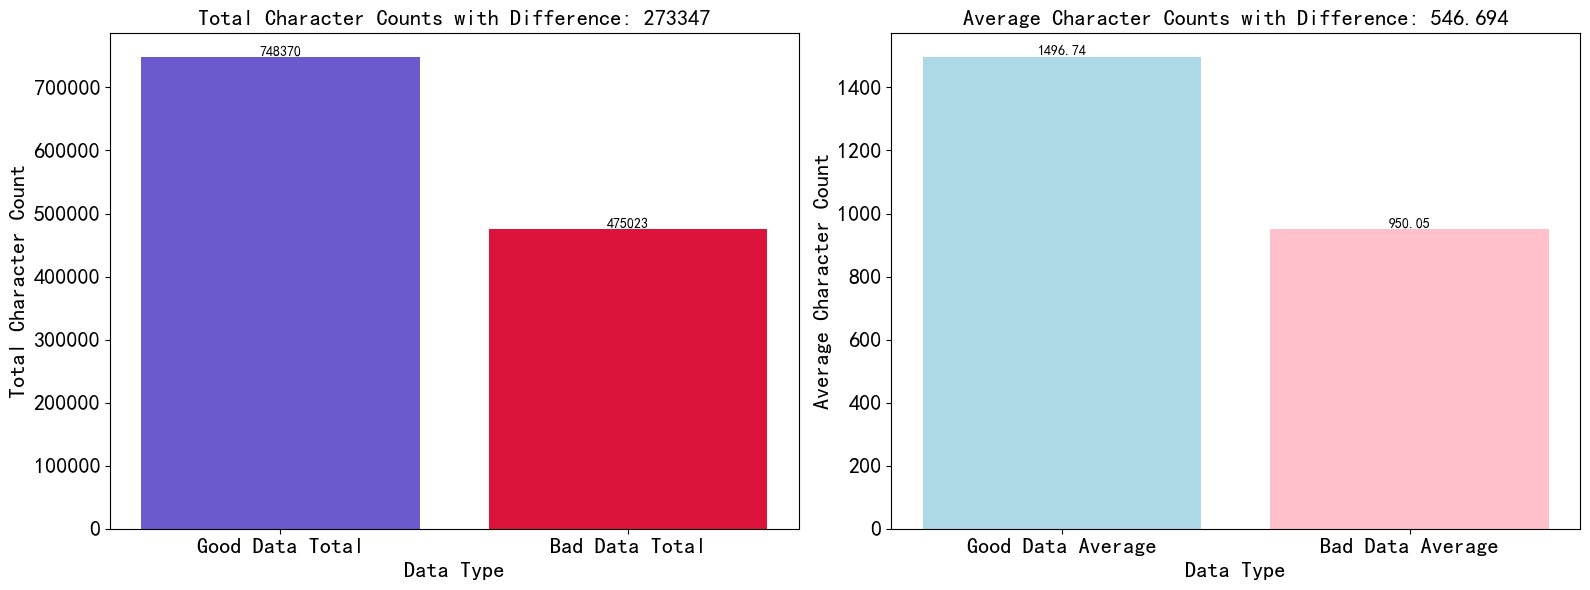

In [8]:
def calculate_stats(dataframe, column_name):
    total_chars = dataframe[column_name].astype(str).apply(len).sum()# 计算指定列中所有字符串的字符总数
    average_chars = total_chars / len(dataframe) # 计算指定列中字符串的平均字符数
    return total_chars, average_chars

# 对 gooddata 和 baddata字符统计
gooddata_total, gooddata_avg = calculate_stats(gooddata, 'content')# 调用 calculate_stats 函数计算 gooddata 列的字符统计，并将结果赋值给 gooddata_total 和 gooddata_avg 
baddata_total, baddata_avg = calculate_stats(baddata, 'content')

# 计算差值
difference_total = gooddata_total - baddata_total # 计算两组数据'content'总字符数的差值
difference_avg = gooddata_avg - baddata_avg

# 创建一个画布和两个子图轴
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 第一个条形图：总字符数
labels_total = ['Good Data Total', 'Bad Data Total']
values_total = [gooddata_total, baddata_total]
bars1 = ax1.bar(labels_total, values_total, color=['slateblue', 'crimson'])

# 在每个柱子上方显示数值
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

ax1.set_title('Total Character Counts with Difference: ' + str(difference_total))
ax1.set_xlabel('Data Type')
ax1.set_ylabel('Total Character Count')

# 第二个条形图：平均字符数
labels_avg = ['Good Data Average', 'Bad Data Average']
values_avg = [gooddata_avg, baddata_avg]
bars2 = ax2.bar(labels_avg, values_avg, color=['lightblue', 'pink'])

# 在每个柱子上方显示数值
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

ax2.set_title('Average Character Counts with Difference: ' + str(difference_avg))
ax2.set_xlabel('Data Type')
ax2.set_ylabel('Average Character Count')

# 调整子图间距
plt.tight_layout()

# 显示图表
plt.show()

In [9]:
# 将标题中的英文字母转换为小写
gooddata['title_lower'] = gooddata['title'].str.lower()
baddata['title_lower'] = baddata['title'].str.lower()

# 去除标点符号和特殊字符，并创建新的列 'title_clean'
gooddata['title_clean'] = gooddata['title_lower'].str.replace(r'[^\w\s]', '', regex=True)
baddata['title_clean'] = baddata['title_lower'].str.replace(r'[^\w\s]', '', regex=True)

# 去除空格   .str.strip()负责去除字符串首尾的空格
gooddata['title_clean'] = gooddata['title_clean'].str.replace(r'\s+', '', regex=True).str.strip()
baddata['title_clean'] = baddata['title_clean'].str.replace(r'\s+', '', regex=True).str.strip()

# 输出gooddata前5行数据的'title', 'title_lower', 'title_clean' 列
gooddata[['title', 'title_clean']].head(5)

,title,title_clean
0,澳门旅游攻略拿走不谢,澳门旅游攻略拿走不谢
1,国外游 | 在济州的海边，自由带着风，落日映着浪漫（三千呆五晚的超省钱攻略！多图预警）,国外游在济州的海边自由带着风落日映着浪漫三千呆五晚的超省钱攻略多图预警
2,坐着火车一路向西，20+days，80%成功！part1西安、兰州、张掖、敦煌,坐着火车一路向西20days80成功part1西安兰州张掖敦煌
3,多人行 | 马来西亚亚庇行,多人行马来西亚亚庇行
4,带妈妈去泰国（曼谷＋清迈）,带妈妈去泰国曼谷清迈


In [10]:
# 输出baddata前5行数据的'title', 'title_clean' 列
baddata[['title', 'title_clean']].head(5)

,title,title_clean
0,云南 狗都不去,云南狗都不去
1,日本旅行，大失所望,日本旅行大失所望
2,泉州不会再来,泉州不会再来
3,某公众号在照搬组内的帖子！！！！这是侵权盗用了吧！！,某公众号在照搬组内的帖子这是侵权盗用了吧
4,一定要找消费观相似的人去旅游,一定要找消费观相似的人去旅游


In [11]:
# 清洗gooddata的'content'列，包括将英文字母转换为小写、去除空格和换行、去除标点符号
gooddata['content_lower'] = gooddata['content'].str.lower()
gooddata['content_clean'] = gooddata['content_lower'].str.replace(r'[^\w\s]', '', regex=True)
gooddata['content_clean'] = gooddata['content_clean'].str.replace(r'\s+', '', regex=True).str.strip()

# 清洗baddata的'content'列
baddata['content_lower'] = baddata['content'].str.lower()
baddata['content_clean'] = baddata['content_lower'].str.replace(r'[^\w\s]', '', regex=True)
baddata['content_clean'] = baddata['content_clean'].str.replace(r'\s+', ' ', regex=True).str.strip()

# 检查清洗结果，输出前5行数据的'content','content_clean'列
gooddata[['content','content_clean']].head(5)

,content,content_clean
0,这次澳门行很成功，下次还来，最最最满意的就是酒店，以前出去玩从来不敢住五星级酒店，但是这...,这次澳门行很成功下次还来最最最满意的就是酒店以前出去玩从来不敢住五星级酒店但是这次朋友帮我找...
1,在夏天，去济州岛的念头一旦蹦出来就无法按回去。 先分享一些在济州岛的图片，看看能不能打动...,在夏天去济州岛的念头一旦蹦出来就无法按回去先分享一些在济州岛的图片看看能不能打动你如果你也因...
2,\n 一开始想直飞喀什，看了眼机型，是之前连续出事故停飞的737m8，怂人如我没敢坐，...,一开始想直飞喀什看了眼机型是之前连续出事故停飞的737m8怂人如我没敢坐所以翻出了很多年前做...
3,\n 啦啦啦啦啦啦，五一去了亚庇不久以前，就筹划着要出一次国，想来想去选择了马来西亚，...,啦啦啦啦啦啦五一去了亚庇不久以前就筹划着要出一次国想来想去选择了马来西亚一是因为可以看海景直...
4,\n 飞机上太无聊了，打字记录一下！有空再整理一下\n我是带妈妈去的所以行程不是很特种...,飞机上太无聊了打字记录一下有空再整理一下我是带妈妈去的所以行程不是很特种兵尽管如此我妈还是抱...


In [12]:
baddata[['content','content_clean']].head(5)

,content,content_clean
0,\n 是哪个ip的人破防了🥺 你这样不更印证你们你们在xhs的营销都是假的了吗🤣 我知...,是哪个ip的人破防了 你这样不更印证你们你们在xhs的营销都是假的了吗 我知道你很急但你先带...
1,\n 编辑在最前面，我都在旅游失败组发帖子了，就说明我真的觉得本次旅行大失败。觉得日本...,编辑在最前面我都在旅游失败组发帖子了就说明我真的觉得本次旅行大失败觉得日本很好或者对我本次旅...
2,\n 这帖子没想到过了挺久还有人回复。评论区百态给大家加点乐子---------南方玩...,这帖子没想到过了挺久还有人回复评论区百态给大家加点乐子南方玩过不少地方第一次觉得一个地方的旅...
3,\n 6.5再更新：ta把我的文章删除后，微xin投诉官方来消息了，投诉不通过🙂🙂因为...,65再更新ta把我的文章删除后微xin投诉官方来消息了投诉不通过因为侵权文章已被删除我真服了...
4,\n 我五一和相处一年多关系很好的舍友一起去日本玩，但是发现我们的分歧很大，因为在校园...,我五一和相处一年多关系很好的舍友一起去日本玩但是发现我们的分歧很大因为在校园里看不出来但是旅...


## 转换时间格式

In [13]:
gooddata['time'] = pd.to_datetime(gooddata['time'])
gooddata['day'] = gooddata['time'].dt.date
gooddata['hour'] = gooddata['time'].dt.hour
gooddata['dayofweek'] = gooddata['time'].dt.day_name()
gooddata.head()

,id,title,link,author,author_id,replies,newest_reply,time,ip,content,title_lower,title_clean,content_lower,content_clean,day,hour,dayofweek
0,307007765,澳门旅游攻略拿走不谢,https://www.douban.com/group/topic/307007765/,秋天的落叶🍂,122947196,8,06-11 19:32,2024-06-07 15:13:06,江苏,这次澳门行很成功，下次还来，最最最满意的就是酒店，以前出去玩从来不敢住五星级酒店，但是这...,澳门旅游攻略拿走不谢,澳门旅游攻略拿走不谢,这次澳门行很成功，下次还来，最最最满意的就是酒店，以前出去玩从来不敢住五星级酒店，但是这...,这次澳门行很成功下次还来最最最满意的就是酒店以前出去玩从来不敢住五星级酒店但是这次朋友帮我找...,2024-06-07,15,Friday
1,307011578,国外游 | 在济州的海边，自由带着风，落日映着浪漫（三千呆五晚的超省钱攻略！多图预警）,https://www.douban.com/group/topic/307011578/,小野青,qingmao13,7,06-09 14:14,2024-06-07 16:42:30,浙江,在夏天，去济州岛的念头一旦蹦出来就无法按回去。 先分享一些在济州岛的图片，看看能不能打动...,国外游 | 在济州的海边，自由带着风，落日映着浪漫（三千呆五晚的超省钱攻略！多图预警）,国外游在济州的海边自由带着风落日映着浪漫三千呆五晚的超省钱攻略多图预警,在夏天，去济州岛的念头一旦蹦出来就无法按回去。 先分享一些在济州岛的图片，看看能不能打动...,在夏天去济州岛的念头一旦蹦出来就无法按回去先分享一些在济州岛的图片看看能不能打动你如果你也因...,2024-06-07,16,Friday
2,306982223,坐着火车一路向西，20+days，80%成功！part1西安、兰州、张掖、敦煌,https://www.douban.com/group/topic/306982223/,毛裤,266214574,16,06-08 17:20,2024-06-06 22:40:38,山东,\n 一开始想直飞喀什，看了眼机型，是之前连续出事故停飞的737m8，怂人如我没敢坐，...,坐着火车一路向西，20+days，80%成功！part1西安、兰州、张掖、敦煌,坐着火车一路向西20days80成功part1西安兰州张掖敦煌,\n 一开始想直飞喀什，看了眼机型，是之前连续出事故停飞的737m8，怂人如我没敢坐，...,一开始想直飞喀什看了眼机型是之前连续出事故停飞的737m8怂人如我没敢坐所以翻出了很多年前做...,2024-06-06,22,Thursday
3,306876563,多人行 | 马来西亚亚庇行,https://www.douban.com/group/topic/306876563/,小鱼儿,69942242,41,06-11 20:02,2024-06-04 17:16:35,广东,\n 啦啦啦啦啦啦，五一去了亚庇不久以前，就筹划着要出一次国，想来想去选择了马来西亚，...,多人行 | 马来西亚亚庇行,多人行马来西亚亚庇行,\n 啦啦啦啦啦啦，五一去了亚庇不久以前，就筹划着要出一次国，想来想去选择了马来西亚，...,啦啦啦啦啦啦五一去了亚庇不久以前就筹划着要出一次国想来想去选择了马来西亚一是因为可以看海景直...,2024-06-04,17,Tuesday
4,307159166,带妈妈去泰国（曼谷＋清迈）,https://www.douban.com/group/topic/307159166/,麻欢,Gokuderatwelve,11,06-11 20:50,2024-06-10 22:08:51,湖南,\n 飞机上太无聊了，打字记录一下！有空再整理一下\n我是带妈妈去的所以行程不是很特种...,带妈妈去泰国（曼谷＋清迈）,带妈妈去泰国曼谷清迈,\n 飞机上太无聊了，打字记录一下！有空再整理一下\n我是带妈妈去的所以行程不是很特种...,飞机上太无聊了打字记录一下有空再整理一下我是带妈妈去的所以行程不是很特种兵尽管如此我妈还是抱...,2024-06-10,22,Monday


In [14]:
baddata['time'] = pd.to_datetime(baddata['time'])
baddata['day'] = baddata['time'].dt.date
baddata['hour'] = baddata['time'].dt.hour
baddata['dayofweek'] = baddata['time'].dt.day_name()
baddata.head()

,id,title,link,author,author_id,replies,newest_reply,time,ip,content,title_lower,title_clean,content_lower,content_clean,day,hour,dayofweek
0,306497018,云南 狗都不去,https://www.douban.com/group/topic/306497018/,momo,182418586,192,06-10 20:00,2024-05-27 17:32:36,广东,\n 是哪个ip的人破防了🥺 你这样不更印证你们你们在xhs的营销都是假的了吗🤣 我知...,云南 狗都不去,云南狗都不去,\n 是哪个ip的人破防了🥺 你这样不更印证你们你们在xhs的营销都是假的了吗🤣 我知...,是哪个ip的人破防了 你这样不更印证你们你们在xhs的营销都是假的了吗 我知道你很急但你先带...,2024-05-27,17,Monday
1,304832926,日本旅行，大失所望,https://www.douban.com/group/topic/304832926/,熊味草莓,230781075,185,06-11 15:52,2024-04-21 03:17:00,浙江,\n 编辑在最前面，我都在旅游失败组发帖子了，就说明我真的觉得本次旅行大失败。觉得日本...,日本旅行，大失所望,日本旅行大失所望,\n 编辑在最前面，我都在旅游失败组发帖子了，就说明我真的觉得本次旅行大失败。觉得日本...,编辑在最前面我都在旅游失败组发帖子了就说明我真的觉得本次旅行大失败觉得日本很好或者对我本次旅...,2024-04-21,3,Sunday
2,305264382,泉州不会再来,https://www.douban.com/group/topic/305264382/,钟摆,Gonderwall,209,06-05 23:45,2024-04-30 15:23:34,北京,\n 这帖子没想到过了挺久还有人回复。评论区百态给大家加点乐子---------南方玩...,泉州不会再来,泉州不会再来,\n 这帖子没想到过了挺久还有人回复。评论区百态给大家加点乐子---------南方玩...,这帖子没想到过了挺久还有人回复评论区百态给大家加点乐子南方玩过不少地方第一次觉得一个地方的旅...,2024-04-30,15,Tuesday
3,306758213,某公众号在照搬组内的帖子！！！！这是侵权盗用了吧！！,https://www.douban.com/group/topic/306758213/,熊味草莓,230781075,54,06-06 12:10,2024-06-01 22:57:18,浙江,\n 6.5再更新：ta把我的文章删除后，微xin投诉官方来消息了，投诉不通过🙂🙂因为...,某公众号在照搬组内的帖子！！！！这是侵权盗用了吧！！,某公众号在照搬组内的帖子这是侵权盗用了吧,\n 6.5再更新：ta把我的文章删除后，微xin投诉官方来消息了，投诉不通过🙂🙂因为...,65再更新ta把我的文章删除后微xin投诉官方来消息了投诉不通过因为侵权文章已被删除我真服了...,2024-06-01,22,Saturday
4,306279358,一定要找消费观相似的人去旅游,https://www.douban.com/group/topic/306279358/,咕咕鸡酱,127959461,52,06-11 22:44,2024-05-23 09:27:36,广东,\n 我五一和相处一年多关系很好的舍友一起去日本玩，但是发现我们的分歧很大，因为在校园...,一定要找消费观相似的人去旅游,一定要找消费观相似的人去旅游,\n 我五一和相处一年多关系很好的舍友一起去日本玩，但是发现我们的分歧很大，因为在校园...,我五一和相处一年多关系很好的舍友一起去日本玩但是发现我们的分歧很大因为在校园里看不出来但是旅...,2024-05-23,9,Thursday


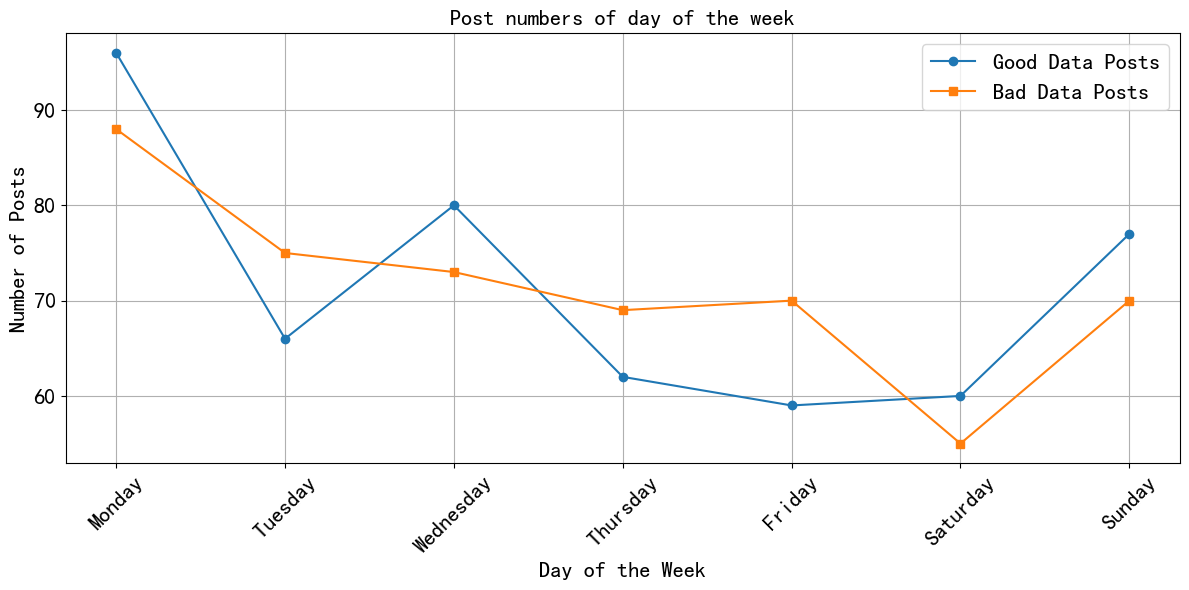

In [15]:
# 统计每个星期几的发帖数
gooddata_day_counts = gooddata['dayofweek'].value_counts()
baddata_day_counts = baddata['dayofweek'].value_counts()

# 准备绘制在同一张图上的折线图
plt.figure(figsize=(12, 6))  # 设置图形大小

# 创建星期一到星期日的顺序列表
week_order_mon_to_sun = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday']

# 绘制 gooddata 的折线图
gooddata_day_counts = gooddata_day_counts.reindex(week_order_mon_to_sun)
plt.plot(gooddata_day_counts.index, gooddata_day_counts.values, label='Good Data Posts', marker='o')

# 绘制 baddata 的折线图
baddata_day_counts = baddata_day_counts.reindex(week_order_mon_to_sun)
plt.plot(baddata_day_counts.index, baddata_day_counts.values, label='Bad Data Posts', marker='s')

# 添加图例
plt.legend()

# 设置图形标题和轴标签
plt.title('Post numbers of day of the week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Posts')

# 显示网格
plt.grid(True)

# 旋转x轴标签，便于阅读
plt.xticks(rotation=45)

# 自动调整子图参数，使之填充整个图像区域
plt.tight_layout()

# 显示图形
plt.show()

## 词频统计和词云图  
### 01 标题词频分析  
停用词表：https://github.com/endNone/stopwords最全的中英文停用词表(3076,包含部分特殊符号) 该词表汇集了多个权威来源的停用词，包括哈工大停用词表、百度停用词表、四川大学机器智能实验室停用词库，以及CSDN和GitHub社区的各类资源，精心筛选和整合了中英文的常见但意义较少的词汇和符号，旨在从文本数据中移除噪音，提升数据处理的质量和效率，适用于各类文本挖掘、情感分析、关键词提取等场景。

In [16]:
# 创建保留词列表
def load_reserved_words(filepath):
    reserved_words = {line.strip() for line in open(filepath, encoding='UTF-8').readlines()}
    return reserved_words

# 创建合并词表
def load_merge_words(filepath):
    merge_dict = {}
    with open(filepath, encoding='UTF-8') as file:
        for line in file.readlines():
            orig, new = line.strip().split()
            merge_dict[orig] = new
    return merge_dict

# 在分词后合并特定词汇
def merge_specific_words(segmented_text, merge_dict):
    words = segmented_text.split()
    merged_words = [merge_dict.get(word, word) for word in words]  # 使用字典.get 方法进行合并
    return ' '.join(merged_words)

# 定义要合并的词汇字典
merge_dict = load_merge_words('mergewords.txt')

# 定义中英文分词函数，保留特定词
def mixed_segmentation(text, stopwords, reserved_words):
    words = text.split()
    segmented_words = []
    for word in words:
        if word in reserved_words:
            segmented_words.extend([word])  # 直接添加保留词
        else:
            segmented_words.extend(jieba.cut(word))  # 对非保留词进行分词
    segmented_words = [word for word in segmented_words if word not in stopwords]
    return ' '.join(segmented_words)

# 在分词和去除停用词后合并特定词汇
def mixed_segmentation_and_merge(text, stopwords, reserved_words, merge_dict):
    segmented_text = mixed_segmentation(text, stopwords, reserved_words)
    merged_text = merge_specific_words(segmented_text, merge_dict)
    return merged_text

# 应用分词、去除停用词和合并词汇的函数到每个 title
def segment_and_merge_texts(series, stopwords, reserved_words, merge_dict):
    return series.apply(lambda x: mixed_segmentation_and_merge(x, stopwords, reserved_words, merge_dict))

# 假设 gooddata 和 baddata 是已经加载的 DataFrame 并且包含 'title_clean' 列
# 创建停用词列表和保留词列表
stopwords = load_reserved_words('stopwords.txt')
reserved_words = load_reserved_words('reservedwords.txt')

# 提取两组数据的'title'列
good_title = gooddata['title_clean']
bad_title = baddata['title_clean']

# 分词、去除停用词和合并词汇
good_title_segmented_merged = segment_and_merge_texts(good_title, stopwords, reserved_words, merge_dict)
bad_title_segmented_merged = segment_and_merge_texts(bad_title, stopwords, reserved_words, merge_dict)

# 词频统计
good_word_counts = Counter(good_title_segmented_merged.str.cat(sep=' ').split())
bad_word_counts = Counter(bad_title_segmented_merged.str.cat(sep=' ').split())

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.531 seconds.
Prefix dict has been built successfully.


In [17]:
# 打印词频统计结果
print("Good Titles Word Counts:", good_word_counts)

Good Titles Word Counts: Counter({'旅游': 113, '成功': 37, '行': 21, '游记': 21, '日本': 20, '攻略': 19, '三天': 18, '多图': 17, '预警': 16, '南京': 16, '四天': 16, '香港': 15, '云南': 15, '晚': 15, '台湾': 14, '周末': 14, '特种兵': 14, '更新': 13, '五一': 13, '一日游': 13, '北京': 13, '自由': 12, '泰国': 12, '春节': 12, '大理': 11, '东京': 11, '吃': 11, '一人游': 10, '三日': 10, '带': 9, '西安': 9, '篇': 9, '大连': 9, '五天': 9, '京都': 9, '青岛': 9, '分享': 9, '两夜': 9, '大学生': 9, '超': 8, '曼谷': 8, '丽江': 8, '洛阳': 8, '淡季': 8, '昆明': 8, '那片': 8, '济州岛': 8, '版': 8, '时间': 8, '澳门': 7, '马来西亚': 7, '体验': 7, '首尔': 7, '自驾': 7, '海': 7, '苏州': 7, '泉州': 7, '跨过': 7, '人均': 7, '厦门': 7, '北疆': 6, '月': 6, '两人游': 6, '三': 6, '第一次': 6, '玩': 6, '日游': 6, '成都': 6, '快乐': 6, '逛': 6, '流水账': 6, '完结': 6, '看海': 6, '两': 6, '上海': 6, '六天': 6, '施工': 5, '扬州': 5, '四晚': 5, '关西': 5, '武汉': 5, '两天': 5, '四夜': 5, '菲律宾': 5, '三人游': 5, '威海': 5, '假期': 5, '城市': 5, '三夜': 5, '女生': 5, '杭州': 5, '美食': 5, '川西': 5, '夜游': 5, '小城': 5, 'solotrip': 5, '日': 5, '广州': 5, 'citywalk': 5, '重庆': 5, '欧洲': 5, '越南': 5, '五晚': 4,

In [18]:
# 打印词频统计结果
print("Bad Titles Word Counts:", bad_word_counts)

Bad Titles Word Counts: Counter({'旅游': 124, '失败': 81, '苏州': 19, '成功': 15, '避雷': 15, '五一': 14, '西安': 13, '日本': 12, '地方': 12, '厦门': 11, '洛阳': 11, '失望': 11, '城市': 10, '长沙': 10, '泉州': 9, '香港': 9, '坑': 9, '新疆': 9, '重庆': 9, '朋友': 8, '半': 8, '境内': 8, '武汉': 8, '青岛': 8, '大理': 8, '体验': 8, '经历': 8, '北京': 8, '桂林': 7, '酒店': 7, '吃': 7, '两天': 7, '行': 7, '云南': 6, '南京': 6, '出租车': 6, '天气': 6, '杭州': 6, '更新': 6, '成都': 6, '带': 6, '一日游': 6, '不想': 6, '踩': 5, '适合': 5, '泰国': 5, '广州': 5, '平潭': 5, '第一次': 5, '景点': 5, '攻略': 5, '海南': 5, '民宿': 5, '昆明': 5, '西藏': 5, '川西': 5, '北疆': 5, '扬州': 5, '端午': 5, '玩': 5, '篇': 5, '找': 4, '游客': 4, '天水': 4, '张家界': 4, '吐槽': 4, '司机': 4, '景德镇': 4, '建议': 4, '春节': 4, '版': 4, '三日': 4, '环游': 4, '预警': 4, '澳门': 4, '山东': 4, '爬': 4, '黄山': 4, '千万': 4, '逛': 4, '搭子': 4, '打卡': 4, '第二次': 4, '淄博': 4, '指南': 4, '自由': 4, '延吉': 4, '曼谷': 4, '阳朔': 4, '周末': 4, '柳州': 4, '菲律宾': 4, '四天': 4, '车': 3, '不好': 3, '香港旅游': 3, '美': 3, '买': 3, '骗': 3, '订': 3, '住': 3, '威海': 3, '机场': 3, '节假日': 3, '台湾': 3, '人多': 3, '顺德': 

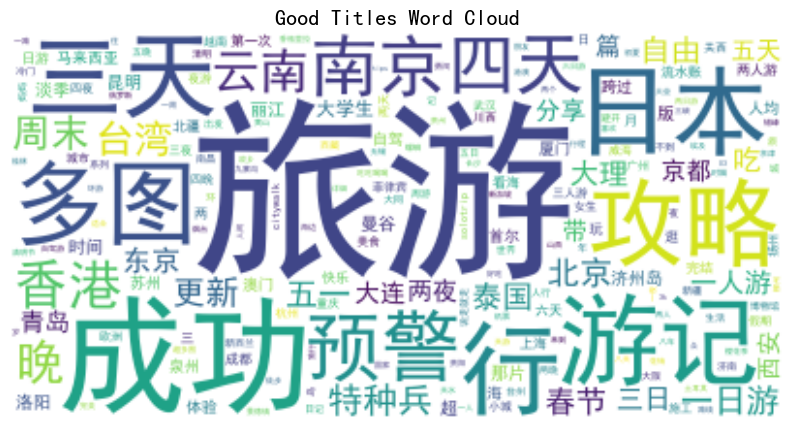

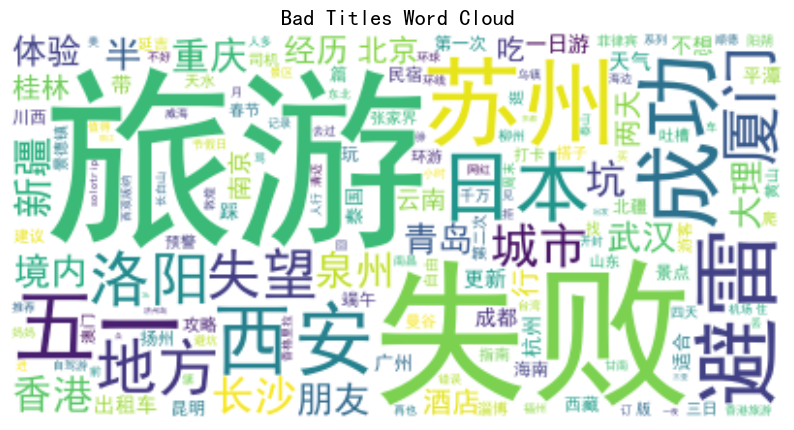

In [19]:
# 生成词云图
def generate_wordcloud(word_counts, title, font_path='path_to_chinese_font.ttf'):
    wordcloud = WordCloud(font_path=font_path,  # 指定中文字体路径
                          background_color='white',
                          max_font_size=100,
                          stopwords=stopwords).generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
    
# 生成词云图
generate_wordcloud(good_word_counts, 'Good Titles Word Cloud', font_path='C:\Windows\Fonts\simhei.ttf')
generate_wordcloud(bad_word_counts, 'Bad Titles Word Cloud', font_path='C:\Windows\Fonts\simhei.ttf')

## TF-IDF提取关键词

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 加载合并词表
def load_merge_words(filepath):
    merge_dict = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            orig, new = line.strip().rsplit(maxsplit=1)  # 以第一个空白字符分割行
            merge_dict[orig] = new if new else orig  # 如果没有提供新词，则使用原词
    return merge_dict

# 在分词后合并特定词汇
def merge_specific_words(segmented_text, merge_dict):
    merged_text = ' '.join(merge_dict.get(word, word) for word in segmented_text.split())
    return merged_text

# 定义中英文分词函数，保留特定词，并合并特定词汇
def mixed_segmentation(text, stopwords, reserved_words, merge_dict):
    words = text.split()
    segmented_words = []
    for word in words:
        if word in reserved_words:
            segmented_words.append(word)  # 直接添加保留词
        else:
            segmented_words.extend(jieba.cut(word))  # 对非保留词进行分词
    segmented_text = ' '.join(segmented_words)
    merged_text = merge_specific_words(segmented_text, merge_dict)
    return merged_text

# 关键词提取函数，现在包括合并词表的处理
def extract_keywords(titles, merge_dict, top_n=10):
    # 将所有标题进行分词、合并特定词汇后合并为一个长字符串
    titles = [mixed_segmentation(title, stopwords, reserved_words, merge_dict) for title in titles]
    segmented_and_merged_text = ' '.join(titles)

    # 将停用词集合转换为列表
    stopwords_list = list(stopwords)

    # 使用TF-IDF算法计算词频-逆文档频率
    vectorizer = TfidfVectorizer(stop_words=stopwords_list, ngram_range=(1, 2))
    tfidf_matrix = vectorizer.fit_transform([segmented_and_merged_text])

    # 获取每个词语（包括单个单词和二元词组）的TF-IDF值
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray().flatten()

    # 将TF-IDF分数与特征名称配对并排序
    sorted_word_tfidf = sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)

    # 提取前top_n个最高得分的词语作为关键词
    top_keywords = [word for word, score in sorted_word_tfidf[:top_n]]

    return top_keywords

# 加载停用词、保留词和合并词表
stopwords = load_reserved_words('stopwords.txt')
reserved_words = load_reserved_words('reservedwords.txt')
merge_dict = load_merge_words('mergewords.txt')

# 关键词提取
good_top_keywords = extract_keywords(good_title_segmented_merged, merge_dict, top_n=10)
bad_top_keywords = extract_keywords(bad_title_segmented_merged, merge_dict, top_n=10)

# 打印关键词
print("Good Titles Top Keywords:", good_top_keywords)
print("Bad Titles Top Keywords:", bad_top_keywords)

Good Titles Top Keywords: ['旅游', '成功', '游记', '日本', '攻略', '三天', '多图', '南京', '四天', '预警']
Bad Titles Top Keywords: ['旅游', '失败', '旅游 失败', '苏州', '成功', '避雷', '五一', '西安', '地方', '日本']


D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'daren', 'hadn', 'herse', 'himse', 'itse', 'lex', 'mayn', 'mightn', 'mon', 'mustn', 'myse', 'needn', 'oughtn', 'shan', '①①', '①②', '①③', '①④', '①⑤', '①⑥', '①⑦', '①⑧', '①⑨', '①ａ', '①ｂ', '①ｃ', '①ｄ', '①ｅ', '①ｆ', '①ｇ', '①ｈ', '①ｉ', '①ｏ', '②①', '②②', '②③', '②④', '②⑤', '②⑥', '②⑦', '②⑧', '②⑩', '②ａ', '②ｂ', '②ｄ', '②ｅ', '②ｆ', '②ｇ', '②ｈ', '②ｉ', '②ｊ', '③①', '③⑩', '③ａ', '③ｂ', '③ｃ', '③ｄ', '③ｅ', '③ｆ', '③ｇ', '③ｈ', '④ａ', '④ｂ', '④ｃ', '④ｄ', '④ｅ', '⑤ａ', '⑤ｂ', '⑤ｄ', '⑤ｅ', '⑤ｆ', '１２', 'ｌｉ', 'ｚｘｆｉｔｌ'] not in stop_words.
  warnings.warn(


## content词频和词云图

In [21]:
# 创建保留词列表
def load_reserved_words(filepath):
    reserved_words = {line.strip() for line in open(filepath, encoding='UTF-8').readlines()}
    return reserved_words

# 创建合并词表
def load_merge_words(filepath):
    merge_dict = {}
    with open(filepath, encoding='UTF-8') as file:
        for line in file.readlines():
            orig, new = line.strip().split()  
            merge_dict[orig] = new
    return merge_dict

# 在分词后合并特定词汇
def merge_specific_words(segmented_text, merge_dict):
    words = segmented_text.split()
    merged_words = [merge_dict.get(word, word) for word in words]  # 使用字典.get 方法进行合并
    return ' '.join(merged_words)

# 定义要合并的词汇字典
merge_dict = load_merge_words('mergewords.txt')

# 定义中英文分词函数，保留特定词
def mixed_segmentation(text, stopwords, reserved_words):
    words = text.split()
    segmented_words = []
    for word in words:
        if word in reserved_words:
            segmented_words.extend([word])  # 直接添加保留词
        else:
            segmented_words.extend(jieba.cut(word))  # 对非保留词进行分词
    segmented_words = [word for word in segmented_words if word not in stopwords]
    return ' '.join(segmented_words)

# 在分词和去除停用词后合并特定词汇
def mixed_segmentation_and_merge(text, stopwords, reserved_words, merge_dict):
    segmented_text = mixed_segmentation(text, stopwords, reserved_words)
    merged_text = merge_specific_words(segmented_text, merge_dict)
    return merged_text

# 应用分词、去除停用词和合并词汇的函数到每个 title
def segment_and_merge_texts(series, stopwords, reserved_words, merge_dict):
    return series.apply(lambda x: mixed_segmentation_and_merge(x, stopwords, reserved_words, merge_dict))

# 创建停用词列表和保留词列表
stopwords = load_reserved_words('stopwords.txt')
reserved_words = load_reserved_words('reservedwords.txt')

# 提取两组数据的'content_clean'列
good_content = gooddata['content_clean']
bad_content = baddata['content_clean']

# 分词、去除停用词和合并词汇
good_content_segmented_merged = segment_and_merge_texts(good_content, stopwords, reserved_words, merge_dict)
bad_content_segmented_merged = segment_and_merge_texts(bad_content, stopwords, reserved_words, merge_dict)

# 词频统计
good_content_word_counts = Counter(good_content_segmented_merged.str.cat(sep=' ').split())
bad_content_word_counts = Counter(bad_content_segmented_merged.str.cat(sep=' ').split())

In [22]:
print("Good Content Word Counts:", good_content_word_counts)

Good Content Word Counts: Counter({'吃': 2053, '酒店': 970, '买': 892, '好吃': 873, '旅游': 812, '时间': 660, '地方': 605, '喜欢': 591, '拍': 587, '晚上': 581, '逛': 540, '朋友': 513, '小时': 465, '博物馆': 458, '机场': 455, '景点': 454, '公园': 453, '推荐': 450, '下午': 440, '不错': 415, '出发': 398, '行程': 396, '店': 394, '打车': 390, '玩': 383, '拍照': 381, '住': 369, '提前': 361, '发现': 358, '一家': 358, '找': 349, '选择': 332, '两个': 329, '味道': 329, '日本': 325, '回': 315, '排队': 312, '路上': 310, '带': 306, '城市': 305, '挺': 303, '体验': 294, '早上': 288, '月': 286, '第二天': 276, '地铁': 274, '建议': 273, '打卡': 270, '游客': 267, '东西': 262, '公交': 251, '便宜': 250, '一点': 247, '景区': 244, '超级': 238, '路': 238, '好看': 237, '车': 236, '攻略': 235, '前': 227, '价格': 223, '行李': 222, '天气': 222, '东京': 221, '旁边': 218, '喝': 217, '民宿': 216, '风景': 215, '第一次': 211, '门票': 209, '照片': 206, '交通': 205, '到达': 204, '这家': 203, '随便': 201, '香港': 201, '京都': 201, '街': 200, '高铁': 200, '计划': 199, '路线': 195, '海边': 194, '分钟': 194, '免费': 193, '门口': 193, '本来': 191, '古城': 187, '适合': 187, '只能': 186,

In [23]:
print("Bad Content Word Counts:", bad_content_word_counts)

Bad Content Word Counts: Counter({'吃': 1145, '旅游': 718, '酒店': 640, '地方': 524, '买': 516, '好吃': 410, '景点': 404, '时间': 367, '晚上': 359, '拍': 343, '小时': 332, '朋友': 323, '司机': 319, '找': 297, '排队': 290, '住': 269, '拍照': 261, '玩': 258, '体验': 241, '景区': 240, '喜欢': 238, '行程': 238, '逛': 236, '不错': 235, '打车': 234, '博物馆': 234, '车': 233, '带': 229, '发现': 228, '问': 227, '游客': 219, '挺': 218, '两个': 213, '城市': 213, '一点': 212, '店': 200, '第二天': 198, '下午': 197, '推荐': 192, '出发': 189, '机场': 189, '东西': 188, '天气': 188, '回': 185, '路上': 185, '选择': 185, '只能': 178, '一家': 175, '门票': 174, '路': 171, '攻略': 167, '提前': 165, '味道': 165, '早上': 165, '不到': 163, '前': 160, '好看': 158, '便宜': 150, '打卡': 146, '民宿': 145, '吃饭': 145, '几个': 143, '地铁': 143, '不好': 142, '价格': 141, '钱': 139, '月': 138, '建议': 137, '公园': 135, '失败': 134, '照片': 134, '风景': 132, '喝': 131, '本来': 131, '公交': 128, '元': 126, '听': 125, '票': 124, '实在': 124, '随便': 123, '高': 122, '讲解': 122, '分钟': 121, '旁边': 121, '日本': 120, '交通': 120, '第一次': 120, '高铁': 119, '导游': 118, '号': 

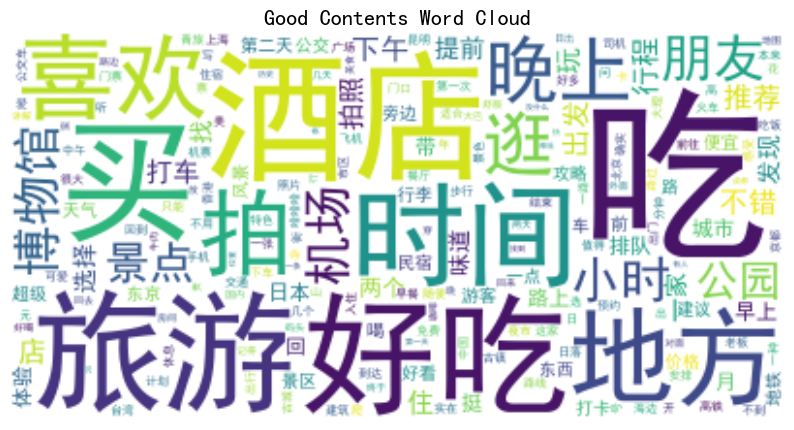

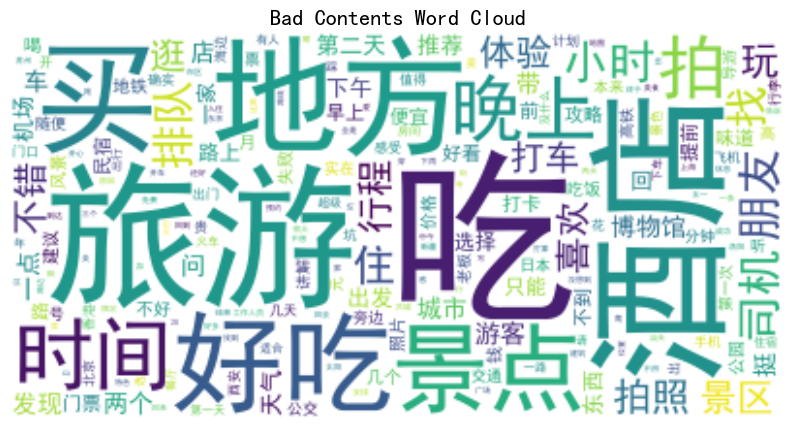

In [24]:
 # 生成词云图
generate_wordcloud(good_content_word_counts, 'Good Contents Word Cloud', font_path='C:\Windows\Fonts\simhei.ttf')
generate_wordcloud(bad_content_word_counts, 'Bad Contents Word Cloud', font_path='C:\Windows\Fonts\simhei.ttf')

## 表情包使用统计

In [25]:
# 确保所有元素都是字符串类型，并连接成一个单一的字符串
good_contents_str_list = gooddata['content'].astype(str).tolist()
all_good_contents_str = ' '.join(good_contents_str_list)

# 定义正则表达式模式来匹配 emoji
emoji_pattern = re.compile(
    '['
    u'\U0001F600-\U0001F64F'  # emoticons
    u'\U0001F300-\U0001F5FF'  # symbols & pictographs
    u'\U0001F680-\U0001F6FF'  # transport & map symbols
    u'\U0001F700-\U0001F77F'  # alchemical symbols
    u'\U0001F780-\U0001F7FF'  # Geometric Shapes Extended
    u'\U0001F800-\U0001F8FF'  # Supplemental Arrows-C
    u'\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
    u'\U0001FA00-\U0001FA6F'  # Chess Symbols
    u'\U0001FA70-\U0001FAFF'  # Symbols and Pictographs Extended-A
    ']+', flags=re.UNICODE)

# 使用正则表达式找到gooddata所有 emoji
good_extracted_emojis = emoji_pattern.findall(all_good_contents_str)

# 将找到的 emoji 字符串分割成单独的字符
good_split_emojis = [char for emoji in good_extracted_emojis for char in emoji]

# 对分割后的 emoji 进行计数
good_content_emoji_counts = Counter(good_split_emojis)

good_emoji_df = pd.DataFrame(list(good_content_emoji_counts.items()), columns=['Emoji', 'Count'])
good_emoji_df_sorted = good_emoji_df.sort_values(by='Count', ascending=False).reset_index()

good_emoji_df_sorted.head(50)

,index,Emoji,Count
0,20,😭,152
1,4,😂,139
2,48,📍,100
3,13,🏻,65
4,9,🥹,58
5,8,😋,58
6,98,🥺,58
7,162,🌟,57
8,26,🥰,48
9,52,💰,44


C:\Users\lenovo\AppData\Local\Temp\ipykernel_137376\1094949441.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(good_emojis, rotation=45, ha='right', fontsize=25)
D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\site-packages\mpld3\mplexporter\exporter.py:47: UserWarning: Glyph 128557 (\N{LOUDLY CRYING FACE}) missing from current font.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\site-packages\mpld3\mplexporter\exporter.py:47: UserWarning: Glyph 128514 (\N{FACE WITH TEARS OF JOY}) missing from current font.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\site-packages\mpld3\mplexporter\exporter.py:47: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from current font.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\

D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128557 (\N{LOUDLY CRYING FACE}) missing from current font.
  func(*args, **kwargs)
D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128514 (\N{FACE WITH TEARS OF JOY}) missing from current font.
  func(*args, **kwargs)
D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from current font.
  func(*args, **kwargs)
D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 127995 (\N{EMOJI MODIFIER FITZPATRICK TYPE-1-2}) missing from current font.
  func(*args, **kwargs)
D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128523 (\N{FACE SAVOURING DELICIOUS FOOD}) missing from current font.
  func(*args, **kwargs)
D:\ProgramFiles2.0\Anac

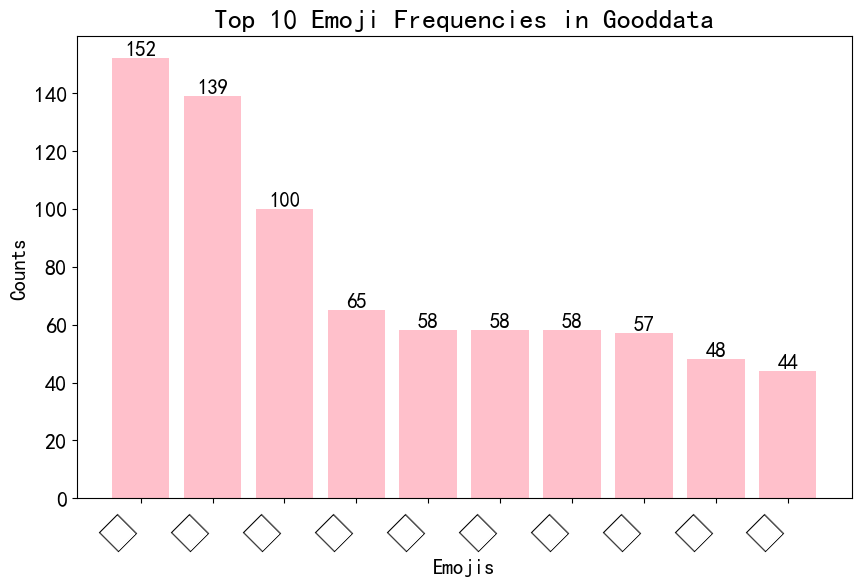

In [26]:
# 获取gooddata_content数量最多的前 10 个 emoji
good_top_emojis = good_content_emoji_counts.most_common(10)

# 准备数据用于绘制柱状图
good_emojis = [e[0] for e in good_top_emojis]
good_counts = [e[1] for e in good_top_emojis]

# 使用 imojify 库来处理 emoji 图片
from imojify import imojify
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
def offset_image(cords, emoji, ax):
    img = plt.imread(imojify.get_img_path(emoji))
    im = OffsetImage(img, zoom=0.08)
    im.image.axes = ax
    ab = AnnotationBbox(im, (cords[0], cords[1]),  frameon=False, pad=0)
    ax.add_artist(ab)
    
# 创建图形和轴对象
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制柱状图
bar_plot = ax.bar(good_emojis, good_counts, color='pink')

# 在每根柱子上显示对应的emoji
for bar in bar_plot:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, yval, ha='center', va='bottom', fontdict={'fontsize': 15})

# 设置图表标题和标签
ax.set_title('Top 10 Emoji Frequencies in Gooddata', fontsize=20)
ax.set_xlabel('Emojis', fontsize=15)
ax.set_xticklabels(good_emojis, rotation=45, ha='right', fontsize=25)
ax.set_ylabel('Counts', fontsize=15)

# 将图像转换成html
html = mpld3.fig_to_html(fig)

# 在web页面中显示图像
from IPython.display import HTML
HTML(html)

In [27]:
# 确保所有元素都是字符串类型，并连接成一个单一的字符串
bad_contents_str_list = baddata['content'].astype(str).tolist()
all_bad_contents_str = ' '.join(bad_contents_str_list)

# 定义一个正则表达式模式来匹配 emoji
emoji_pattern = re.compile(
    '['
    u'\U0001F600-\U0001F64F'  # emoticons
    u'\U0001F300-\U0001F5FF'  # symbols & pictographs
    u'\U0001F680-\U0001F6FF'  # transport & map symbols
    u'\U0001F700-\U0001F77F'  # alchemical symbols
    u'\U0001F780-\U0001F7FF'  # Geometric Shapes Extended
    u'\U0001F800-\U0001F8FF'  # Supplemental Arrows-C
    u'\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
    u'\U0001FA00-\U0001FA6F'  # Chess Symbols
    u'\U0001FA70-\U0001FAFF'  # Symbols and Pictographs Extended-A
    ']+', flags=re.UNICODE)

# 使用正则表达式找到baddata所有 emoji
bad_extracted_emojis = emoji_pattern.findall(all_bad_contents_str)

# 将找到的 emoji 字符串分割成单独的字符
bad_split_emojis = [char for emoji in bad_extracted_emojis for char in emoji]

# 对分割后的 emoji 进行计数
bad_content_emoji_counts = Counter(bad_split_emojis)

bad_emoji_df = pd.DataFrame(list(bad_content_emoji_counts.items()), columns=['Emoji', 'Count'])
bad_emoji_df_sorted = bad_emoji_df.sort_values(by='Count', ascending=False).reset_index()

bad_emoji_df_sorted.head(50)

,index,Emoji,Count
0,14,😂,108
1,27,😭,64
2,2,😅,55
3,11,🏻,39
4,28,🥲,31
5,20,🌟,30
6,4,🥹,28
7,100,🚉,28
8,3,😇,23
9,118,📍,21


C:\Users\lenovo\AppData\Local\Temp\ipykernel_137376\412670982.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bad_emojis, rotation=45, ha='right', fontsize=25)
D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\site-packages\mpld3\mplexporter\exporter.py:47: UserWarning: Glyph 128514 (\N{FACE WITH TEARS OF JOY}) missing from current font.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\site-packages\mpld3\mplexporter\exporter.py:47: UserWarning: Glyph 128557 (\N{LOUDLY CRYING FACE}) missing from current font.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\site-packages\mpld3\mplexporter\exporter.py:47: UserWarning: Glyph 128517 (\N{SMILING FACE WITH OPEN MOUTH AND COLD SWEAT}) missing from current font.
  fig.savefig(io.BytesIO(), format='png', dpi=fig.dpi)
D:\ProgramFiles2.0\

D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128514 (\N{FACE WITH TEARS OF JOY}) missing from current font.
  func(*args, **kwargs)
D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128557 (\N{LOUDLY CRYING FACE}) missing from current font.
  func(*args, **kwargs)
D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128517 (\N{SMILING FACE WITH OPEN MOUTH AND COLD SWEAT}) missing from current font.
  func(*args, **kwargs)
D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 127995 (\N{EMOJI MODIFIER FITZPATRICK TYPE-1-2}) missing from current font.
  func(*args, **kwargs)
D:\ProgramFiles2.0\Anaconda3\envs\homework\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 129394 (\N{SMILING FACE WITH TEAR}) missing from current font.
  func(*args, **kwargs)


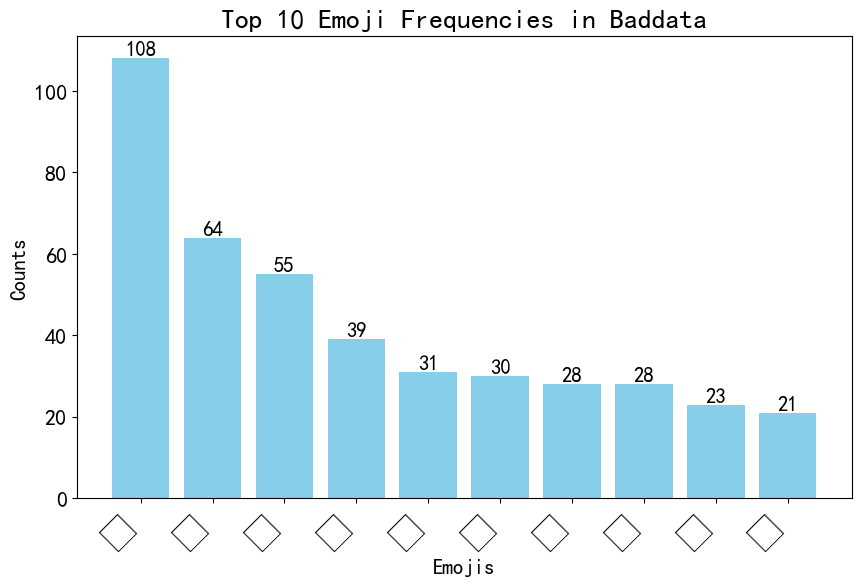

In [28]:
# 获取baddata_content数量最多的前 10 个 emoji
bad_top_emojis = bad_content_emoji_counts.most_common(10)

# 准备数据用于绘制柱状图
bad_emojis = [e[0] for e in bad_top_emojis]
bad_counts = [e[1] for e in bad_top_emojis]
    
# 创建图形和轴对象
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制柱状图
bar_plot = ax.bar(bad_emojis, bad_counts, color='skyblue')

# 在每根柱子上显示对应的emoji
for bar in bar_plot:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, yval, ha='center', va='bottom', fontdict={'fontsize': 15})

# 设置图表标题和标签
ax.set_title('Top 10 Emoji Frequencies in Baddata', fontsize=20)
ax.set_xlabel('Emojis', fontsize=15)
ax.set_xticklabels(bad_emojis, rotation=45, ha='right', fontsize=25)
ax.set_ylabel('Counts', fontsize=15)

# 将图像转换成html
html = mpld3.fig_to_html(fig)

# 在web页面中显示图像
from IPython.display import HTML
HTML(html)